In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from astropy.nddata import Cutout2D
from astropy import units as u

## A Look at a Palomar-Gattini Stacked Image (and SExtractor Generated Images)

In [2]:
data_file_ident = 'stack_fs359_fid722_q2.fits.sq0.fits'
data_file_aper = 'aper.fits'
data_file_obj = 'object.fits'
data_file_minusobj = 'minusobject.fits'
data_file_segment = 'segment.fits'
data_file_back = "back.fits"

In [3]:
ident_data   = fits.getdata(data_file_ident, 0)
aper_data   = fits.getdata(data_file_aper, 0)
obj_data   = fits.getdata(data_file_obj, 0)
minusobj_data   = fits.getdata(data_file_minusobj, 0)
segment_data   = fits.getdata(data_file_segment, 0)
back_data   = fits.getdata(data_file_back, 0)

In [4]:
fits.info(data_file_ident)

Filename: stack_fs359_fid722_q2.fits.sq0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     106   ()      
  1  SCI           1 ImageHDU       110   (1064, 1064)   float64   
  2  WHT           1 ImageHDU        56   (1064, 1064)   float64   


In [5]:
ident_header = fits.getheader(data_file_ident, 0)

In [6]:
ident_data[0:2]

array([[-16.31853067,  32.67912244,  51.81720104, ...,  -5.16550001,
         -4.79772297, -29.21252529],
       [-35.45664555,  12.82625574,  21.55000244, ..., -25.45262516,
        -22.84549141, -42.44501544]])

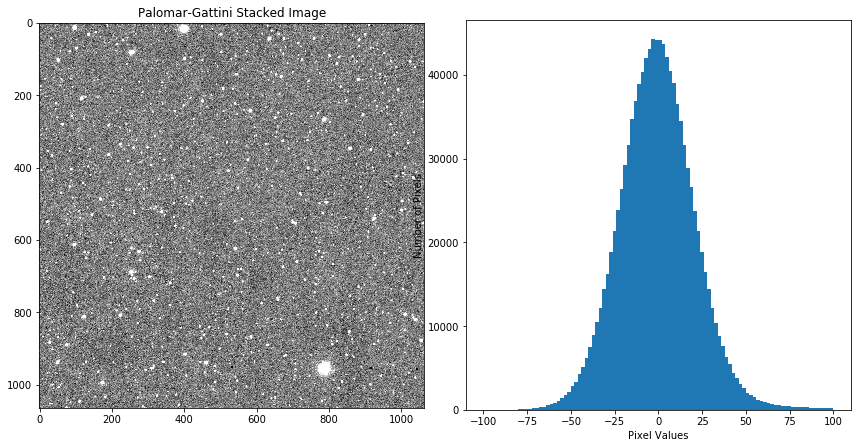

In [7]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
fig.tight_layout()

ax[0].imshow(ident_data,vmin = -75,vmax = 75,cmap=plt.cm.gray)

ax[0].set_title('Palomar-Gattini Stacked Image')
ax[1].set_xlabel("Pixel Values")
ax[1].set_ylabel("Number of Pixels")
ax[1].hist(ident_data.flatten(), range = (-100,100),bins=100);

In [8]:
print(f"The image has a shape [height,width] of {ident_data.shape}")

The image has a shape [height,width] of (1064, 1064)


In [9]:
print(f"The image has a maximum value of {ident_data.max():.2f}")
print(f"The image has a minimum value of {ident_data.min():.2f}")

The image has a maximum value of 357435.62
The image has a minimum value of -16865.78


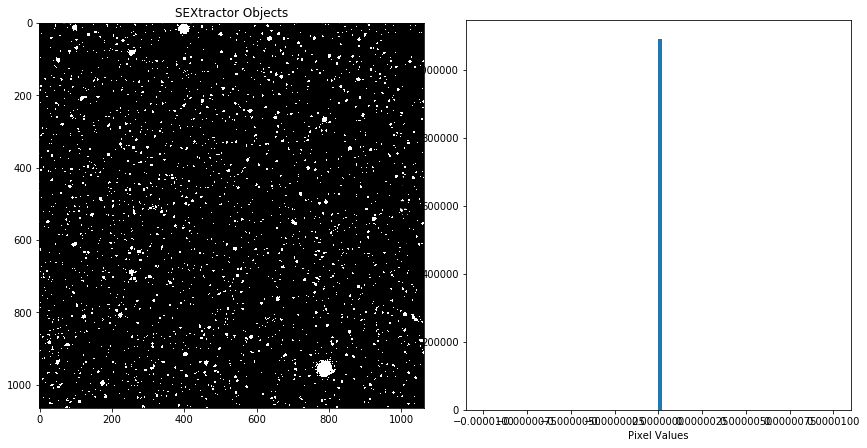

In [10]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
fig.tight_layout()

ax[0].imshow(segment_data,cmap=plt.cm.gray, vmin = 0, vmax = 1)

ax[0].set_title('SEXtractor Objects')
ax[1].set_xlabel("Pixel Values")
ax[1].set_ylabel("Number of Pixels")
ax[1].hist(segment_data.flatten(),range = (-.00001,.00001),bins=100);

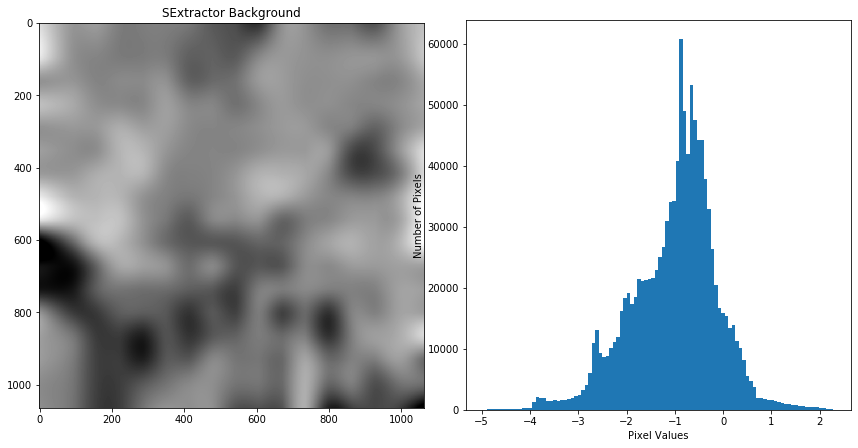

In [11]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
fig.tight_layout()

ax[0].imshow(back_data,cmap=plt.cm.gray, vmin = -4, vmax = 2)

ax[0].set_title('SExtractor Background')
ax[1].set_xlabel("Pixel Values")
ax[1].set_ylabel("Number of Pixels")
ax[1].hist(back_data.flatten(),bins=100);

In [12]:
print(f"The image has a shape [height,width] of {back_data.shape}")

The image has a shape [height,width] of (1064, 1064)


In [13]:
print(f"The image has a maximum value of {back_data.max():.2f}")
print(f"The image has a minimum value of {back_data.min():.2f}")

The image has a maximum value of 2.29
The image has a minimum value of -4.97


## Creating a Simulated .fits File

In [14]:
def plotCutout(img, title = None, clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None, clim=(-60, 300)):
    """Make a nice looking plot of a small image"""
    if loc is None:
        fig, ax = plt.subplots(figsize=(15,15))
        fig.subplots_adjust(right=0.8, bottom=0.34)
    else:
        ax = fig.add_subplot(loc)

    # coordinate of the edge (assuming a square image)
    xe = img.shape[0] // 2.

    if title is None:
        title = "min = %.1f, max=%.1f" % (img.min(), img.max())
    
    ax.set_title(title, fontsize=14)
    plt.imshow(img, origin='lower', interpolation='nearest',
           extent=(-xe, xe, -xe, xe),
           cmap='jet', aspect='auto')
    plt.clim(*clim)
    plt.colorbar().set_label(clabel)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

In [15]:
def makePSF(shape, x0, y0, sigmaPSF):
    # Add a (Gaussian) PSF of width sigmaPSF, centered on (x0, y0)
    xx = np.arange(shape[0]) - shape[0]/2.+0.5
    yy = np.arange(shape[1]) - shape[1]/2.+0.5
    
    r = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    psf = np.exp(-r**2./2./sigmaPSF) / (2*np.pi*sigmaPSF)
    return psf

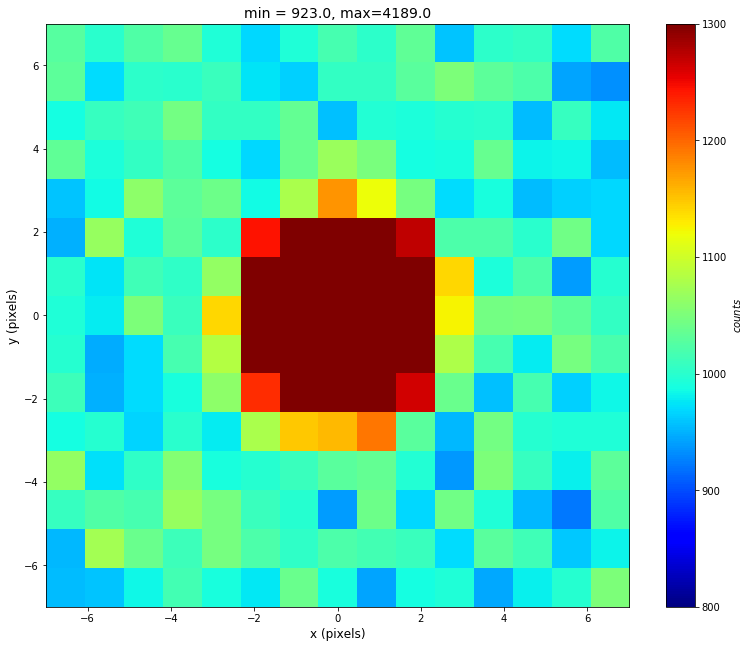

In [16]:
np.random.seed(43)

Atrue = 30000.12   # the true source flux
xdim = 15         # width of the image
ydim = 15         # height of the image
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
skyBg = 1000    # sky background flux (photons / second)

image = np.zeros((xdim, ydim))
image = Atrue * makePSF(image.shape, 0, 0, sigmaPSF)
image += skyBg
image = np.random.poisson(image)

plotCutout(image, clim=(800, 1300))
simulatedImage = image    # save it for later

#### Plotting a cutout from the stacked image to compare

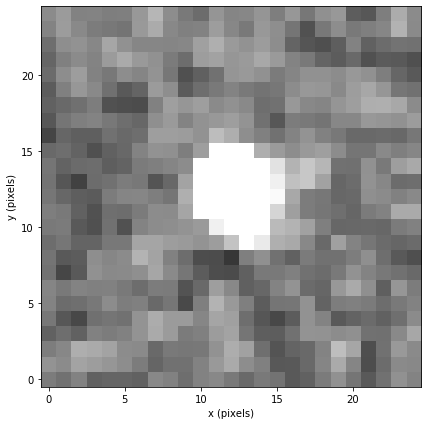

In [17]:
plt.figure(figsize = (7,7))
position = (673, 673)
size = (25, 25)     # pixels
cutout = Cutout2D(ident_data, position, size)

plt.xlabel('x (pixels)')
plt.ylabel('y (pixels)')

plt.imshow(cutout.data, origin='lower', cmap = 'gray', vmin = -100, vmax = 100)

### Making a .fits File with One Simulated Star

In [18]:
image

array([[ 956,  960,  984, 1015,  990,  976, 1040,  991,  944,  989,  995,
         946,  981,  998, 1051],
       [ 953, 1074, 1040, 1012, 1047, 1022, 1005, 1022, 1016, 1010,  971,
        1030, 1014,  962,  982],
       [1008, 1024, 1018, 1067, 1048, 1009,  999,  939, 1042,  968, 1044,
         995,  953,  923, 1024],
       [1065,  972, 1005, 1055,  991,  998, 1010, 1029, 1035,  996,  937,
        1050, 1008,  980, 1032],
       [ 989,  999,  967, 1001,  979, 1078, 1149, 1156, 1191, 1029,  954,
        1045,  999,  995,  995],
       [1011,  949,  971,  990, 1061, 1231, 1644, 1845, 1536, 1263, 1039,
         958, 1018,  966,  984],
       [ 998,  948,  971, 1018, 1084, 1655, 2638, 3283, 2621, 1645, 1081,
        1018,  978, 1047, 1019],
       [ 995,  979, 1051, 1010, 1141, 1791, 3287, 4189, 3241, 1759, 1126,
        1045, 1047, 1032, 1007],
       [1000,  974, 1014, 1005, 1065, 1638, 2642, 3285, 2544, 1626, 1141,
         993, 1022,  939,  999],
       [ 950, 1066,  994, 1029, 1002,

In [19]:
hdu = fits.PrimaryHDU(image)

In [20]:
hdu.writeto('simstar.fits')

OSError: File 'simstar.fits' already exists.

In [21]:
simstar = 'simstar.fits'
simstarData = fits.getdata(simstar, 0)
simstarHeader = fits.getheader(simstar, 0)

It works!


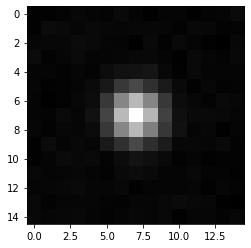

In [22]:
plt.imshow(simstarData, cmap = 'gray')
print('It works!')

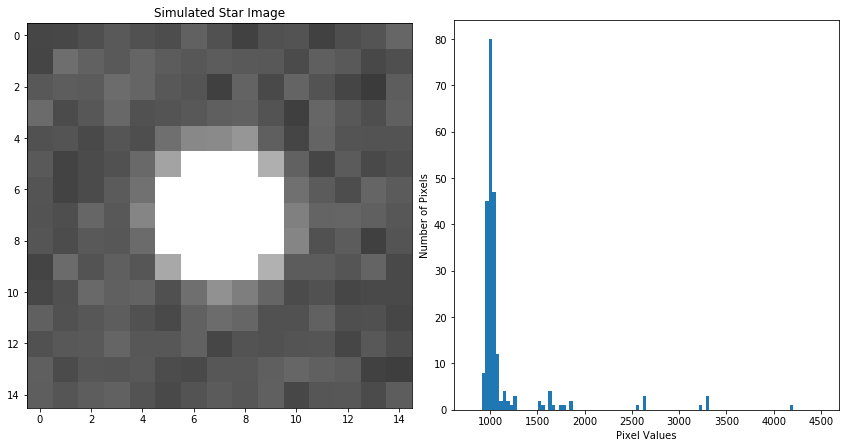

In [23]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
fig.tight_layout()

ax[0].imshow(simstarData,cmap=plt.cm.gray, vmin = 750, vmax = 1500)

ax[0].set_title('Simulated Star Image')
ax[1].set_xlabel("Pixel Values")
ax[1].set_ylabel("Number of Pixels")
ax[1].hist(simstarData.flatten(), range = (800,4500),bins=100);

Here is the image generated with DS9:

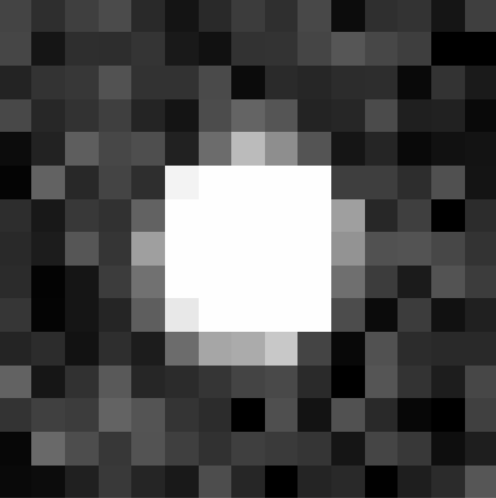

I tried to run it through SExtractor, but it doesn't like the data.

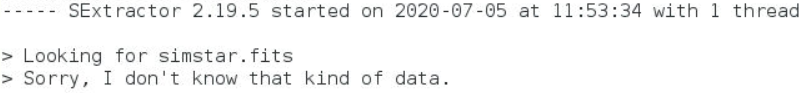

## Why doesnt SExtractor like my image?

#### stack_fs359_fid722_q2.fits.sq0.fits vs. simstar.fits

stack_fs359_fid722_q2.fits.sq0.fits:

In [24]:
fits.info(data_file_ident)

Filename: stack_fs359_fid722_q2.fits.sq0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     106   ()      
  1  SCI           1 ImageHDU       110   (1064, 1064)   float64   
  2  WHT           1 ImageHDU        56   (1064, 1064)   float64   


In [25]:
print(f"The image has a shape [height,width] of {ident_data.shape}")
print(f"The image has a maximum value of {ident_data.max():.2f}")
print(f"The image has a minimum value of {ident_data.min():.2f}")

The image has a shape [height,width] of (1064, 1064)
The image has a maximum value of 357435.62
The image has a minimum value of -16865.78


In [26]:
ident_header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
STACKID =               448396                                                  
QUADPOS =                    2                                                  
NIGHTID =                  629                                                  
HIERARCH quadid_beg = 3634062                                                   
HIERARCH quadid_end = 3634090                                                   
NUMQUADS=                    8                                                  
EXPTIME =            71.262912                                                  
DATEBEG = '2020-06-22 07:48:41.478000'                                          
DATEEND = '2020-06-22 07:50:

simstar.fits:

In [27]:
fits.info(simstar)

Filename: simstar.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (15, 15)   int64   


In [28]:
print(f"The image has a shape [height,width] of {simstarData.shape}")
print(f"The image has a maximum value of {simstarData.max():.2f}")
print(f"The image has a minimum value of {simstarData.min():.2f}")

The image has a shape [height,width] of (15, 15)
The image has a maximum value of 4189.00
The image has a minimum value of 923.00


In [29]:
simstarHeader

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   15                                                  
NAXIS2  =                   15                                                  
EXTEND  =                    T                                                  

According to the SExtractor documentation:

SExtractor accepts images stored in FITS [12]. Both “Basic FITS” (one single header and one single body) and MEF files are recognized. Binary SExtractor catalogs produced from MEF images are MEF files themselves. If the catalog output format is set to ASCII, all catalogs from the individual extensions are concatenated in one big file; the EXT_NUMBER catalog parameter can be used to tell which extension the detection belongs to.


I $think$ that my image is a "Basic FITS" but I'm not sure.

But, here's the differences in the files that I see:

* Palomar-Gattini Stacked Image:
    * BITPIX = 8
    * NAXIS = 0
        * NAXIS1 = 15
        * NAXIS2 = 15
    * PrimaryHDU and 2 ImageHDUs
    * Format: float64
    * Obviously more header info
* Simulated Star Image:
    * BITPIX = 64
    * NAXIS = 2
    * Only PrimaryHDU
    * Format: int64

Maybe its the floats?

In [30]:
imageFloat = image.astype(float)

In [31]:
hdu = fits.PrimaryHDU(imageFloat)
hdu.writeto('simstarFloat.fits')

OSError: File 'simstarFloat.fits' already exists.

In [32]:
simstarFloat = 'simstarFloat.fits'
simstarData = fits.getdata(simstar, 0)
simstarHeader = fits.getheader(simstar, 0)

In [33]:
fits.info(simstarFloat)

Filename: simstarFloat.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (15, 15)   float64   


Looks like that was the solution!

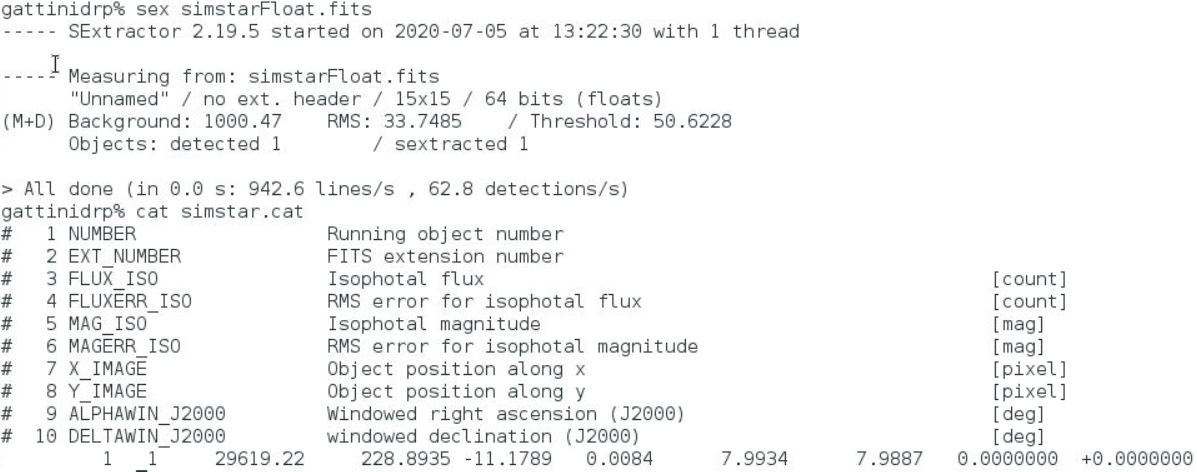

The SExtractor parameters also seem pretty good:
* True Flux = 30,000.12 -> FLUX_ISO = 29,619.22 ± 228.8935

## Adding More Sources to the Simulated Image

In [34]:
def makePSF(shape, x0, y0, sigmaPSF):
    # Add a (Gaussian) PSF of width sigmaPSF, centered on (x0, y0)
    xx = np.arange(shape[0]) - shape[0]/2.+0.5
    yy = np.arange(shape[1]) - shape[1]/2.+0.5
    
    r = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    psf = np.exp(-r**2./2./sigmaPSF) / (2*np.pi*sigmaPSF)
    return psf

In [35]:
def plotCutout(img, title = None, clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None, clim=(-60, 300)):
    """Make a nice looking plot of a small image"""
    if loc is None:
        fig, ax = plt.subplots(figsize=(15,15))
        fig.subplots_adjust(right=0.8, bottom=0.34)
    else:
        ax = fig.add_subplot(loc)

    # coordinate of the edge (assuming a square image)
    xe = img.shape[0] // 2.

    if title is None:
        title = "min = %.1f, max=%.1f" % (img.min(), img.max())
    
    ax.set_title(title, fontsize=14)
    plt.imshow(img, origin='lower', interpolation='nearest',
           extent=(-xe, xe, -xe, xe),
           cmap='jet', aspect='auto')
    plt.clim(*clim)
    plt.colorbar().set_label(clabel)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

In [36]:
Atrue = np.random.randint(1200,70000,2500)
Atrue

array([ 2009, 10381, 49008, ..., 24875, 15506, 35296])

In [37]:
x0 = np.random.uniform(low=0, high=1064, size=(50,))
y0 = np.random.uniform(low=0, high=1064, size=(50,))
x0, y0

(array([ 366.99404066,  879.78120555,  200.70406797,  491.29102342,
         243.00240035,  983.55918031,  213.04972994,  226.55102181,
         593.58383082,   20.12480091,  581.84886848,  986.64793786,
         835.62166683,  948.8631587 , 1031.22390028,  556.17872347,
         126.84987338,  129.65993048,  162.50286913, 1001.89503556,
         701.44375589,  146.79877141,  665.94454624,  229.15875088,
         842.06521897,  502.86937621,  389.23912347,  421.88423011,
        1037.17102204,   31.64563409,  734.43940943,  848.83000021,
         719.57850816, 1034.58106044,  905.9017141 ,  554.98122863,
         313.48341281, 1021.01561153,  255.89356576,  771.73317909,
         869.68337757,  158.5387662 ,   63.91719904,  373.74664217,
         421.81800165,  907.30402886,  309.62897614,  943.8271031 ,
        1059.72618276,  677.137377  ]),
 array([ 884.97134961,  299.87235968,  114.75321822,  670.30172372,
          93.07689999,   30.84268889,  778.68378531,  715.2302228 ,
        

In [38]:
np.random.seed(43)

Atrue = Atrue   # the true source flux
xdim = 1064         # width of the image
ydim = 1064         # height of the image
muXtrue = x0     # source x centroid 
muYtrue = y0     # source y centroid
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
skyBg = 1000    # sky background flux (photons / second)

image = np.zeros((xdim, ydim))
image = Atrue * makePSF(image.shape, x0, y0, sigmaPSF)
image += skyBg
image = np.random.poisson(image)

plotCutout(image, clim=(800, 6500))
simulatedImage = image    # save it for later

ValueError: operands could not be broadcast together with shapes (1,1064) (50,) 